# Plot the training curves of the hit tagging models

A Hit Tagging model aims to predict the tag (0 for vertex activity, 1 for single particle, 2 for noise) of hits of an event in SFG. In this notebook we plot the training curve of a given hit tagging model

### Define parameters

In [1]:
# j=19 # id of the model (useful when testing many models)
j=""

### Define paths

In [2]:
model_path=f"../../models_weights/hittag_model_{j}.torch"
train_set_path="/scratch4/maubin/data/hittag_train"
scaler_file_path="../../sfgnets/datasets/scalers/scaler_hittag.p"
training_dict_path=f"../../results/hit_tagging_training_dict_{j}.torch"

In [3]:
import os
import sys
import pickle as pk
import torch.nn as nn
import tqdm
import numpy as np
import torch
import importlib
import matplotlib.pyplot as plt


# Manually specify the GPUs to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

torch.multiprocessing.set_sharing_strategy('file_system')

    
from sfgnets import hit_tag_net
from sfgnets.utils import minkunet

importlib.reload(hit_tag_net);

Using cache found in /scratch/.maubin/cache/torch/hub/adeelh_pytorch-multi-class-focal-loss_master


In [4]:
# generate dataset
dataset=hit_tag_net.SparseEvent(train_set_path,
                                scaler_file=scaler_file_path)

train_loader, valid_loader, test_loader=hit_tag_net.split_dataset(dataset,
                                                                    batch_size = 32,
                                                                    train_fraction=0.8,
                                                                    val_fraction=0.19,
                                                                    seed=7)

In [5]:
from warmup_scheduler_pytorch import WarmUpScheduler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 3

# Define the model
model = minkunet.MinkUNet34B(in_channels=4, out_channels=num_classes, D=3).to(device)
# print(model)

# Print the total number of trainable parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable params: {pytorch_total_params}")
    
# Loss function
loss_func = nn.CrossEntropyLoss()

# Optimizer and scheduler
lr = 0.01
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-9, weight_decay=0.01)
num_cycles = 20
num_warmup_steps = 5
cosine_annealing_steps = len(train_loader) * num_cycles
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=cosine_annealing_steps, T_mult=1, eta_min=lr/100)
warmup_scheduler = WarmUpScheduler(optimizer, lr_scheduler,
                                   len_loader=1,
                                   warmup_steps=len(train_loader) * num_warmup_steps,
                                   warmup_start_lr=lr/1000,
                                   warmup_mode='linear')

Total trainable params: 36229923


In [6]:
training_dict=torch.load(training_dict_path)

Maximum F1 score: 	82.72%
Precision: 		82.19%
Recall: 		83.30%


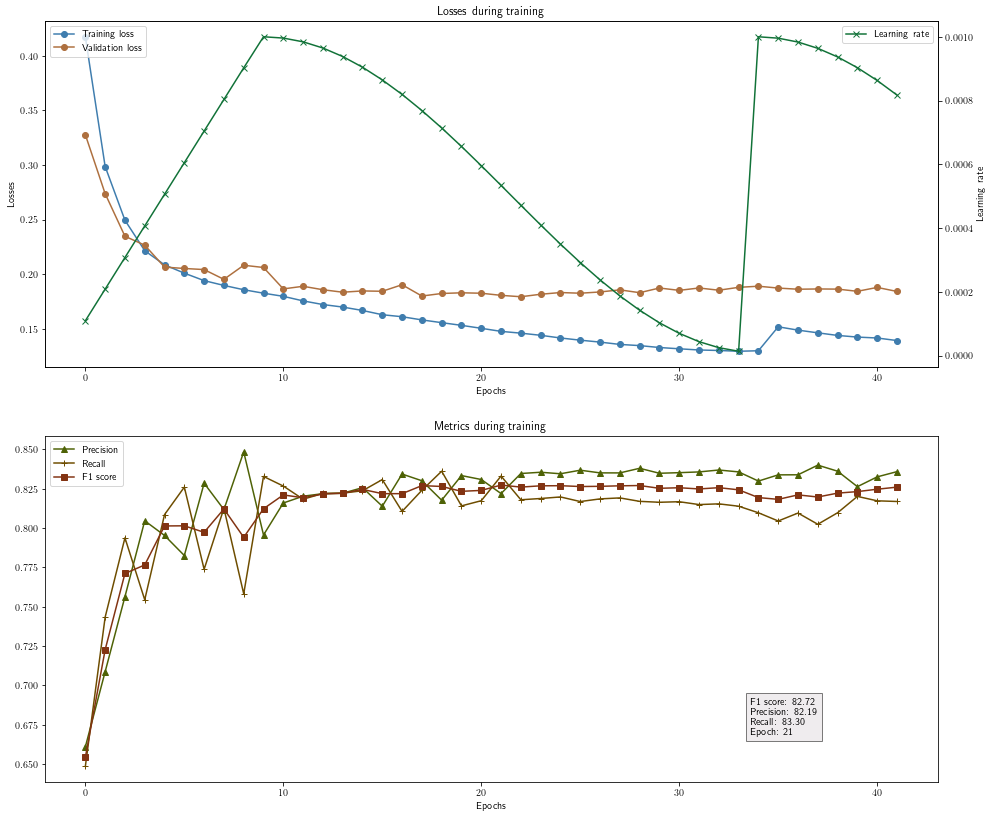

In [7]:
color_list = ["#3f7dae","#ae703f",'#117238', '#4e6206', '#6e4d00','#823312','#851433']

fig,axes=plt.subplots(2,1,figsize=(16,14), facecolor="white")

axes[0].plot(training_dict["training_loss"],label="Training loss", color=color_list[0], marker="o")
axes[0].plot(training_dict["validation_loss"],label="Validation loss", color=color_list[1], marker="o")
ax_lr=axes[0].twinx()
ax_lr.plot(training_dict["learning_rate"],label="Learning rate", color=color_list[2], marker="x")
# ax_lr.set_yscale('log')
ax_lr.set_ylabel('Learning rate')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Losses')
axes[0].set_title('Losses during training')
axes[0].legend(loc='upper left')
ax_lr.legend(loc='upper right')

axes[1].plot(training_dict["precision"],label="Precision",  color=color_list[3], marker="^")
axes[1].plot(training_dict["recall"],label="Recall", color=color_list[4], marker="+")
axes[1].plot(training_dict["f1_score"],label="F1 score",color=color_list[5], marker="s")
axes[1].set_xlabel('Epochs')
axes[1].set_title('Metrics during training')
axes[1].legend()

k=np.argmax(training_dict["f1_score"])

txt_string=f"F1 score:            {training_dict['f1_score'][k]*100:.2f}%\n"
txt_string+=f"Precision:           {training_dict['precision'][k]*100:.2f}%\n"
txt_string+=f"Recall:                {training_dict['recall'][k]*100:.2f}%\n"
txt_string+=f"Epoch:                {k}"

y_pos= min(np.min(training_dict['precision']),np.min(training_dict['recall']),np.min(training_dict['f1_score']))+0.1*(max(np.max(training_dict['precision']),np.max(training_dict['recall']),np.max(training_dict['f1_score']))- min(np.min(training_dict['precision']),np.min(training_dict['recall']),np.min(training_dict['f1_score'])))
axes[1].text(len(training_dict['precision'])*0.8,y_pos, txt_string, multialignment='left', bbox=dict(facecolor='#e0dade', alpha=0.5))

# fig.suptitle(f"Training results for ")

print(f"Maximum F1 score: \t{training_dict['f1_score'][k]*100:.2f}%")
print(f"Precision: \t\t{training_dict['precision'][k]*100:.2f}%")
print(f"Recall: \t\t{training_dict['recall'][k]*100:.2f}%")
fig.show()